# Task 1

# Logistic regression 

### Initialization

In [10]:
%matplotlib inline
import numpy as np
import math
import h5py
import random
import pyJHTDB
import time as tt
import matplotlib.pyplot as plt
from scipy import ndimage as ndi
from skimage import filters
import skimage.morphology as morphology
from skimage.morphology import square
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from matplotlib import cm
import scipy.io as sio
import time
import matplotlib.animation as animation
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import Ridge,RidgeCV,RidgeClassifierCV,LogisticRegressionCV,LogisticRegression
from sklearn.model_selection import cross_val_score, cross_val_predict, cross_validate
from sklearn import metrics
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, StratifiedKFold # import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large',
         'font.family':"Times New Roman"}
pylab.rcParams.update(params)

# load shared library
lTDB = pyJHTDB.libJHTDB()
#initialize webservices
lTDB.initialize()

#Add token
auth_token  = "edu.jhu.burgers-2e898d7f"
lTDB.add_token(auth_token)

dataset = 'transition_bl'

spatialInterp  = 0  # no spatial interpolation
temporalInterp = 0  # no time interpolation
FD4NoInt       = 40 # 4th-order FD, no spatial interpolation

### Get training and test data

In [2]:
#Read Training and Test data
data_t0 = h5py.File('data_t0_TNT_45x30x48.h5','r')
data_t1000 = h5py.File('data_t1000_TNT_45x30x48.h5','r')
Z=data_t0['Z']
X=data_t0['X']
Y=data_t0['Y']
x=X[1,:,1]
y=Y[:,1,1]
z=Z[1,1,:]

### Display data label

In [3]:
list(data_t0.keys())

['TNT',
 'X',
 'Y',
 'Z',
 'dudx',
 'dudy',
 'dudz',
 'dvdx',
 'dvdy',
 'dvdz',
 'dwdx',
 'dwdy',
 'dwdz',
 'u',
 'up',
 'v',
 'vp',
 'w',
 'x',
 'y']

### Training ($t=0$) and Test ($t=1000$) data

In [4]:
niy=Z.shape[0]
nix=Z.shape[1]
niz=Z.shape[2]
X_t0=np.zeros((nix*niy*niz,16),dtype=np.float64)
y_t0_TNT=np.zeros((nix*niy*niz,1),dtype=object)
y_t0=np.zeros((nix*niy*niz,1),dtype=np.float64)
X_t1000=np.zeros((nix*niy*niz,16),dtype=np.float64)
y_t1000_TNT=np.zeros((nix*niy*niz,1),dtype=object)
y_t1000=np.zeros((nix*niy*niz,1),dtype=np.float64)

X_t0[:,0]=data_t0['u']
X_t0[:,1]=data_t0['v']
X_t0[:,2]=data_t0['w']
X_t0[:,3]=data_t0['up']
X_t0[:,4]=data_t0['vp']
X_t0[:,5]=data_t0['dudx']
X_t0[:,6]=data_t0['dudy']
X_t0[:,7]=data_t0['dudz']
X_t0[:,8]=data_t0['dvdx']
X_t0[:,9]=data_t0['dvdy']
X_t0[:,10]=data_t0['dvdz']
X_t0[:,11]=data_t0['dwdx']
X_t0[:,12]=data_t0['dwdy']
X_t0[:,13]=data_t0['dwdz']
X_t0[:,14]=data_t0['x']
X_t0[:,15]=data_t0['y']
y_t0_TNT[:,0]=data_t0['TNT']

X_t1000[:,0]=data_t1000['u']
X_t1000[:,1]=data_t1000['v']
X_t1000[:,2]=data_t1000['w']
X_t1000[:,3]=data_t1000['up']
X_t1000[:,4]=data_t1000['vp']
X_t1000[:,5]=data_t1000['dudx']
X_t1000[:,6]=data_t1000['dudy']
X_t1000[:,7]=data_t1000['dudz']
X_t1000[:,8]=data_t1000['dvdx']
X_t1000[:,9]=data_t1000['dvdy']
X_t1000[:,10]=data_t1000['dvdz']
X_t1000[:,11]=data_t1000['dwdx']
X_t1000[:,12]=data_t1000['dwdy']
X_t1000[:,13]=data_t1000['dwdz']
X_t1000[:,14]=data_t1000['x']
X_t1000[:,15]=data_t1000['y']
y_t1000_TNT[:,0]=data_t1000['TNT']

### One-Hot encoding

In [5]:
# One-Hot encoding of t0ing data
onehot_encoder = OneHotEncoder()
onehot_encoded = onehot_encoder.fit_transform(y_t0_TNT).toarray()
y_t0[:,0]=onehot_encoded[:,0]
if y_t0_TNT[0] == 'NT' and y_t0[0,0] == 1.:
    print('Making sure T=1 and NT=0 in training data:')
    y_t0=1-y_t0
if y_t0_TNT[0] == 'T' and y_t0[0,0] == 0.:
    print('Making sure T=1 and NT=0 in training data:')
    y_t0=1-y_t0
    
# One-Hot encoding of t1000 data
onehot_encoded = onehot_encoder.fit_transform(y_t1000_TNT).toarray()
y_t1000[:,0]=onehot_encoded[:,0]
if y_t1000_TNT[0] == 'NT' and y_t1000[0,0] == 1.:
    print('Making sure T=1 and NT=0 in test data:')
    y_t1000=1-y_t1000
if y_t1000_TNT[0] == 'T' and y_t1000[0,0] == 0.:
    print('Making sure T=1 and NT=0 in test data:')
    y_t1000=1-y_t1000

y_t0=y_t0.ravel()
y_t1000=y_t1000.ravel()

Making sure T=1 and NT=0 in training data:
Making sure T=1 and NT=0 in test data:


### Standardize features

In [6]:
# Standarize features
scaler = StandardScaler()
X_t0_std = scaler.fit_transform(X_t0)
X_t1000_std = scaler.fit_transform(X_t1000)

### Logistic Regression with cross validation using GridsearchCV

In [7]:
# defining parameter range 
grid={"C":np.logspace(-3,3,7), "penalty":["l2"]}# l1 lasso l2 ridge
logreg=LogisticRegression(solver='sag',max_iter=1e4)
logreg_cv=GridSearchCV(logreg,grid,cv=3,verbose=10)
logreg_cv.fit(X_t0_std,y_t0)
print("tuned hpyerparameters :(best parameters) ",logreg_cv.best_params_,logreg_cv.best_estimator_)
print("accuracy :",logreg_cv.best_score_)
logreg_cv_predictions = logreg_cv.predict(X_t1000_std)
print(metrics.classification_report(y_t1000, logreg_cv_predictions)) 
print('Mean square error',metrics.mean_squared_error(y_t1000,logreg_cv_predictions))

Fitting 3 folds for each of 7 candidates, totalling 21 fits
[CV] C=0.001, penalty=l2 .............................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .... C=0.001, penalty=l2, score=0.9418055555555556, total=   0.2s
[CV] C=0.001, penalty=l2 .............................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


[CV] .... C=0.001, penalty=l2, score=0.9916666666666667, total=   0.3s
[CV] C=0.001, penalty=l2 .............................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s


[CV] .... C=0.001, penalty=l2, score=0.9531018518518518, total=   0.3s
[CV] C=0.01, penalty=l2 ..............................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.8s remaining:    0.0s


[CV] ..... C=0.01, penalty=l2, score=0.8890277777777778, total=   0.3s
[CV] C=0.01, penalty=l2 ..............................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    1.1s remaining:    0.0s


[CV] ..... C=0.01, penalty=l2, score=0.9973611111111111, total=   0.4s
[CV] C=0.01, penalty=l2 ..............................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.5s remaining:    0.0s


[CV] ..... C=0.01, penalty=l2, score=0.9731018518518518, total=   0.8s
[CV] C=0.1, penalty=l2 ...............................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    2.3s remaining:    0.0s


[CV] ...... C=0.1, penalty=l2, score=0.8875462962962963, total=   1.9s
[CV] C=0.1, penalty=l2 ...............................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    4.3s remaining:    0.0s


[CV] ...... C=0.1, penalty=l2, score=0.9982407407407408, total=   4.1s
[CV] C=0.1, penalty=l2 ...............................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    8.3s remaining:    0.0s


[CV] ...... C=0.1, penalty=l2, score=0.9811111111111112, total=   4.7s
[CV] C=1.0, penalty=l2 ...............................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   13.1s remaining:    0.0s


[CV] ...... C=1.0, penalty=l2, score=0.9226388888888889, total=   8.3s
[CV] C=1.0, penalty=l2 ...............................................
[CV] ...... C=1.0, penalty=l2, score=0.9989351851851852, total=  17.9s
[CV] C=1.0, penalty=l2 ...............................................
[CV] ................. C=1.0, penalty=l2, score=0.98625, total=  18.0s
[CV] C=10.0, penalty=l2 ..............................................
[CV] ..... C=10.0, penalty=l2, score=0.9439814814814815, total=  20.0s
[CV] C=10.0, penalty=l2 ..............................................
[CV] ..... C=10.0, penalty=l2, score=0.9992592592592593, total=  43.9s
[CV] C=10.0, penalty=l2 ..............................................
[CV] ..... C=10.0, penalty=l2, score=0.9899537037037037, total=  32.4s
[CV] C=100.0, penalty=l2 .............................................
[CV] .... C=100.0, penalty=l2, score=0.9477314814814815, total=  26.1s
[CV] C=100.0, penalty=l2 .............................................
[CV] .

[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:  6.3min finished


tuned hpyerparameters :(best parameters)  {'C': 1000.0, 'penalty': 'l2'} LogisticRegression(C=1000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=10000.0,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='sag', tol=0.0001, verbose=0, warm_start=False)
accuracy : 0.9795061728395061
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     54729
         1.0       1.00      0.98      0.99     10071

   micro avg       1.00      1.00      1.00     64800
   macro avg       1.00      0.99      0.99     64800
weighted avg       1.00      1.00      1.00     64800

Mean square error 0.002638888888888889


### Prediction on test data ($t=1000$)

In [8]:
y_pred= logreg_cv_predictions.reshape((niy,niz,nix))
y_t1000= y_t1000.reshape((niy,niz,nix))

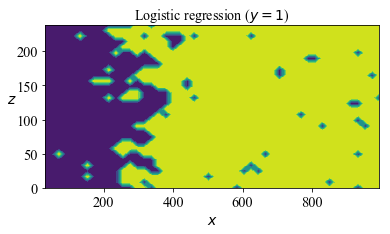

In [11]:
plt.figure(figsize=(6,3));
plt.contourf(x,z,y_pred[2,:,:])
plt.xlabel('$x$', fontsize=14)
plt.ylabel('$z$',rotation=0, fontsize=14)
plt.title("Logistic regression ($y=1$)", fontsize=14)
plt.ylim(z[0],z[niz-1])
plt.savefig('logistic.png',dpi=300)

### Report Mean Squared Error

In [12]:
metrics.mean_squared_error(y_pred.flatten(),y_t1000.flatten())

0.002638888888888889